In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import random
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

import seaborn as sns
import sys
import pickle
from tensorflow.keras.utils import to_categorical
import keras
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims

import tensorflow.keras.backend as K
from tensorflow import keras
from PIL import Image


In [ ]:
# from google.colab import drive, files
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
# Load labels dataset
full_df = pd.read_csv('/content/gdrive/MyDrive/DL_files/full_df.csv')
print(full_df.shape[0])

6392


In [ ]:
images_folder_path = '/content/gdrive/MyDrive/DL_files/preprocessed_images'
# os.chdir(images_folder_path)

image_size=224

GENERAL FUNCTIONS

In [ ]:
def has_disease(text, disease):
  if disease in text:
    return 1
  else:
    return 0

In [ ]:
# SAMPLE FOR NORMAL IMAGES
# TO MAKE BINARY CLASSIFICATION BALANCED I WILL SAMPLE DIFFERENT NUMBER OF NORMAL EYES EACH TIME

def sample_normal_eyes(sample_size):
  left_normal = full_df.loc[(full_df.N == 1) & (full_df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(sample_size//2,random_state=42).values
  right_normal = full_df.loc[(full_df.N == 1) & (full_df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(sample_size//2,random_state=42).values
  return left_normal, right_normal

In [ ]:
def create_dataset(image_category, label):
  labels = []
  dataset = []
  for i in range(np.size(image_category,0)): # !!
    for img in tqdm(image_category[i]):
      image_path = os.path.join(images_folder_path,img)
      try:
        image = cv2.imread(image_path,cv2.IMREAD_COLOR)
        image = cv2.resize(image,(image_size,image_size))
      except:
        continue

      dataset.append([np.array(image),np.array(label[i])])

  random.shuffle(dataset)
  return dataset

In [ ]:
# Plot some images for the dataset

def plot_images(dataset, label0, label1):
  plt.figure(figsize=(10,6))
  for i in range(8):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    category = dataset[sample][1]
    if category == 0:
        label = label0
    else:
        label = label1
    plt.subplot(2,4,i+1)
    plt.imshow(image_rgb)
    plt.xlabel(label)
  plt.tight_layout()
  plt.show()

In [ ]:
def define_train_test_valid(dataset, image_size):

  #Deviding dataset into x(features and y(target))
  x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
  y = np.array([i[1] for i in dataset])

  # Normalize Features
  x = x.astype(np.float32)

  # Normalize the image to the range [0, 1]
  x = x / 255.0

  # Split in training testing and validation
  x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=0)
  x_validation, x_test, y_validation, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=0)

  return x_train, x_validation, x_test, y_train, y_validation, y_test

In [ ]:
def plot_cm(cm):
  plt.figure(figsize=(8, 6))
  sns.set(font_scale=1.2)  # Adjust the font scale for better readability
  sns.heatmap(cm.astype(int), annot=True, fmt=".2f", cmap="Blues",
              xticklabels=['Normal', 'Cataract'],
              yticklabels=['Normal', 'Cataract'])

  plt.text(0.5, 0.6, 'TP', ha='center', va='center', fontweight='bold', color='red')
  plt.text(0.5, 1.6, 'FP', ha='center', va='center', fontweight='bold', color='red')
  plt.text(1.5, 0.6, 'FN', ha='center', va='center', fontweight='bold', color='red')
  plt.text(1.5, 1.6, 'TN', ha='center', va='center', fontweight='bold', color='red')

  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix")
  plt.show()

In [ ]:
def plot_train_valid_results(hist):

  # Plot training and validation loss
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(hist.history['loss'], label='Training Loss')
  plt.plot(hist.history['val_loss'], label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  # Plot training and validation accuracy
  plt.subplot(1, 2, 2)
  plt.plot(hist.history['accuracy'], label='Training Accuracy')
  plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  # Show the plots
  plt.tight_layout()
  plt.show()

In [ ]:
def only_disease(disease):
  if disease == "C":
    return (full_df.N == 0) & (full_df.D ==0) & (full_df.G ==0) & (full_df.A ==0)
  elif disease == "D":
    return (full_df.N == 0) & (full_df.C ==0) & (full_df.G ==0) & (full_df.A ==0)
  elif disease == "G":
    return (full_df.N == 0) & (full_df.C ==0) & (full_df.D ==0) & (full_df.A ==0)
  elif disease == "A":
    return (full_df.N == 0) & (full_df.C ==0) & (full_df.D ==0) & (full_df.G ==0)

In [ ]:
def sample_for_balance(sample_size):

  LN = full_df.loc[(full_df.N == 1) & (full_df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(sample_size//2,random_state=42).values
  RN = full_df.loc[(full_df.N == 1) & (full_df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(sample_size//2,random_state=42).values
  N = np.concatenate((LN, RN),axis=0)

  LC = full_df.loc[(full_df.C ==1) & only_disease("C") & (full_df.left_cataract == 1)]["Left-Fundus"].values
  RC = full_df.loc[(full_df.C ==1) & only_disease("C") & (full_df.right_cataract == 1)]["Right-Fundus"].values
  C = np.concatenate((LC,RC),axis=0)

  LD = full_df.loc[(full_df.D ==1) & only_disease("D") & (full_df.left_diabetes == 1)]["Left-Fundus"].sample(sample_size//2,random_state=42).values
  RD = full_df.loc[(full_df.D ==1) & only_disease("D") & (full_df.right_diabetes == 1)]["Right-Fundus"].sample(sample_size//2,random_state=42).values
  D = np.concatenate((LD, RD),axis=0)

  LG = full_df.loc[(full_df.G ==1) & only_disease("G") & (full_df.left_glaucoma == 1)]["Left-Fundus"].values
  RG = full_df.loc[(full_df.G ==1) & only_disease("G") & (full_df.right_glaucoma == 1)]["Right-Fundus"].values
  G = np.concatenate((LG, RG),axis=0)

  LA = full_df.loc[(full_df.A ==1) & only_disease("A") & (full_df.left_AMD == 1)]["Left-Fundus"].values
  RA = full_df.loc[(full_df.A ==1) & only_disease("A") & (full_df.right_AMD == 1)]["Right-Fundus"].values
  A = np.concatenate((LA, RA),axis=0)

  return N, C, D, G, A

In [ ]:
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)

# checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
#                              save_weights_only=False,save_freq=32)

earlystop = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1)

CREATION OF DATASET FOR CATARACT BINARY CLASSIFICATION

In [ ]:
# FOR CATARACT (BINARY)

# Add a new column with values=1 if in the diagnosis we have the word cataract
full_df["left_cataract"] = full_df["Left-Diagnostic Keywords"].apply(lambda x: has_disease(x, "cataract"))
full_df["right_cataract"] = full_df["Right-Diagnostic Keywords"].apply(lambda x: has_disease(x, "cataract"))

# Create np.array with the names of the files we will use
left_cataract = full_df.loc[(full_df.C == 1) & (full_df.left_cataract == 1)]["Left-Fundus"].values
right_cataract = full_df.loc[(full_df.C == 1) & (full_df.right_cataract == 1)]["Right-Fundus"].values

print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

# Concatenate left and right eye images
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
print("Lenght=",len(cataract))

In [ ]:
# These normals are for cataract
left_normal, right_normal = sample_normal_eyes(len(cataract))
normal = np.concatenate((left_normal,right_normal),axis=0)
print(len(cataract),len(normal))

In [ ]:
# Create Dataset for cataract-normal (1,0)

dataset_nc = create_dataset((normal,cataract),(0,1)) # NC->normal-cataract
len(dataset_nc)

In [ ]:
# Write dataset into drive

with open('/content/gdrive/MyDrive/DL_files/my_new_datasets/cataract_dataset.pkl', 'wb') as file:
  pickle.dump(dataset_nc, file)

CREATION OF DATASET FOR DIABETES BINARY CLASSIFICATION

In [ ]:
# FOR DIABETIC RETINOPATHY (BINARY)

full_df["left_diabetes"] = full_df["Left-Diagnostic Keywords"].apply(lambda x: has_disease(x, "retinopathy"))
full_df["right_diabetes"] = full_df["Right-Diagnostic Keywords"].apply(lambda x: has_disease(x, "retinopathy"))

# Create np.array with the names of the files we will use
left_diabetes = full_df.loc[(full_df.D == 1) & (full_df.left_diabetes == 1)]["Left-Fundus"].values
right_diabetes = full_df.loc[(full_df.D == 1) & (full_df.right_diabetes == 1)]["Right-Fundus"].values

print("Number of images in left diabetes: {}".format(len(left_diabetes)))
print("Number of images in right diabetes: {}".format(len(right_diabetes)))

# Concatenate left and right eye images
diabetes = np.concatenate((left_diabetes,right_diabetes),axis=0)
print("Lenght=",len(diabetes))

In [ ]:
# These normals are for Diabetes
left_normal, right_normal = sample_normal_eyes(len(diabetes))
normal = np.concatenate((left_normal,right_normal),axis=0)
print(len(diabetes),len(normal))

In [ ]:
# Create Dataset for diabetic-normal (1,0)

dataset_nd = create_dataset((normal,diabetes),(0,1)) # ND->normal-diabetes
len(dataset_nd)

In [ ]:
# Write dataset into drive

with open('/content/gdrive/MyDrive/DL_files/my_new_datasets/diabetes_dataset.pkl', 'wb') as file:
  pickle.dump(dataset_nd, file)

CREATION OF DATASET FOR GLAUCOMA BINARY CLASSIFICATION

In [ ]:
# FOR GLAUCOMA (BINARY)

full_df["left_glaucoma"] = full_df["Left-Diagnostic Keywords"].apply(lambda x: has_disease(x, "glaucoma"))
full_df["right_glaucoma"] = full_df["Right-Diagnostic Keywords"].apply(lambda x: has_disease(x, "glaucoma"))

# Create np.array with the names of the files we will use
left_glaucoma = full_df.loc[(full_df.G ==1) & (full_df.left_glaucoma == 1)]["Left-Fundus"].values
right_glaucoma = full_df.loc[(full_df.G ==1) & (full_df.right_glaucoma == 1)]["Right-Fundus"].values

print("Number of images in left glaucoma: {}".format(len(left_glaucoma)))
print("Number of images in right glaucoma: {}".format(len(right_glaucoma)))

# Concatenate left and right eye images
glaucoma = np.concatenate((left_glaucoma,right_glaucoma),axis=0)
print("Lenght=", len(glaucoma))

In [ ]:
# These normals are for glaucoma
left_normal, right_normal = sample_normal_eyes(len(glaucoma))
normal = np.concatenate((left_normal,right_normal),axis=0)
print(len(glaucoma),len(normal))

In [ ]:
# Create Dataset for glaucoma-normal (1,0)

dataset_ng = create_dataset((normal,glaucoma),(0,1)) # NG->normal-glaucoma
len(dataset_ng)

In [ ]:
# Write dataset into drive

with open('/content/gdrive/MyDrive/DL_files/my_new_datasets/glaucoma_dataset.pkl', 'wb') as file:
  pickle.dump(dataset_ng, file)

CREATION OF DATASET FOR AMD BINARY CLASSIFICATION

In [ ]:
# FOR AMD (BINARY)

full_df["left_AMD"] = full_df["Left-Diagnostic Keywords"].apply(lambda x: has_disease(x, "macular degeneration"))
full_df["right_AMD"] = full_df["Right-Diagnostic Keywords"].apply(lambda x: has_disease(x, "macular degeneration"))

# Create np.array with the names of the files we will use
left_AMD = full_df.loc[(full_df.A ==1) & (full_df.left_AMD == 1)]["Left-Fundus"].values
right_AMD = full_df.loc[(full_df.A ==1) & (full_df.right_AMD == 1)]["Right-Fundus"].values

print("Number of images in left AMD: {}".format(len(left_AMD)))
print("Number of images in right AMD: {}".format(len(right_AMD)))

AMD = np.concatenate((left_cataract,right_AMD),axis=0)
print("Length",len(AMD))

In [ ]:
# These normals are for AMD
left_normal, right_normal = sample_normal_eyes(len(AMD))
normal = np.concatenate((left_normal,right_normal),axis=0)
print(len(AMD),len(normal))

In [ ]:
# Create Dataset for AMD-normal (1,0)

dataset_na = create_dataset((normal,AMD),(0,1)) # NA->normal-AMD
len(dataset_na)

In [ ]:
# Write dataset into drive

with open('/content/gdrive/MyDrive/DL_files/my_new_datasets/AMD_dataset.pkl', 'wb') as file:
  pickle.dump(dataset_na, file)

CREATION OF DATASET FOR MULTI-LABEL CLASSIFICATION

In [ ]:
# Downsample the data so we have almost equal samples from each label
N, C, D, G, A = sample_for_balance(500)
print(N.shape, C.shape, D.shape, G.shape, A.shape)

In [ ]:
# Normal -> 0
# Cataract -> 1
# Diabetes -> 2
# Glaucoma -> 3
# AMD -> 4

multi_dataset = create_dataset((N, C, D, G, A), (0, 1, 2, 3, 4))

In [ ]:
# Write dataset into drive

with open('/content/gdrive/MyDrive/DL_files/my_new_datasets/multi_dataset.pkl', 'wb') as file:
  pickle.dump(multi_dataset, file)

# *INCEPTION* MODEL : BINARY CLASSIFICATION

In [ ]:
InceptionV3 = InceptionV3(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
# Freeze layers so they don’t change during training

# Freezing the layers from the pre-trained model is vital.
# This is because you don’t want the weights in those layers to be re-initialized.
# If they are, then you will lose all the learning that has already taken place.
# This will be no different from training the model from scratch.
for layer in InceptionV3.layers:
    layer.trainable = False

In [ ]:
x = tf.keras.layers.Flatten()( InceptionV3.output )
outputs = tf.keras.layers.Dense(1, activation='sigmoid')( x )

model = tf.keras.models.Model( InceptionV3.input , outputs )


In [ ]:
model.summary()

In [ ]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"]) # Categioral crossentropy for multiclass

#Classification Accuracy is what we usually mean, when we use the term accuracy. It is the ratio of number of correct predictions to the total number of input samples.

#It works well only if there are equal number of samples belonging to each class.

# For example, consider that there are 98% samples of class A and 2% samples of class B in our training set.
# Then our model can easily get 98% training accuracy by simply predicting every training sample belonging to class A.

# When the same model is tested on a test set with 60% samples of class A and 40% samples of class B,
# then the test accuracy would drop down to 60%. Classification Accuracy is great, but gives us the false sense of achieving high accuracy.

# The real problem arises, when the cost of misclassification of the minor class samples are very high.
# If we deal with a rare but fatal disease, the cost of failing to diagnose the disease of a sick person is much higher than the cost of sending a healthy person to more tests.

# Wsave = model.get_weights()

In [ ]:
model.save('/content/gdrive/MyDrive/DL_files/binary_model.keras')


CATARACT

In [ ]:
# LOAD THE DATASET

# For binary Normal-Cataract
with open('/content/gdrive/MyDrive/DL_files/my_new_datasets/cataract_dataset.pkl', 'rb') as file:
    dataset_nc = pickle.load(file)

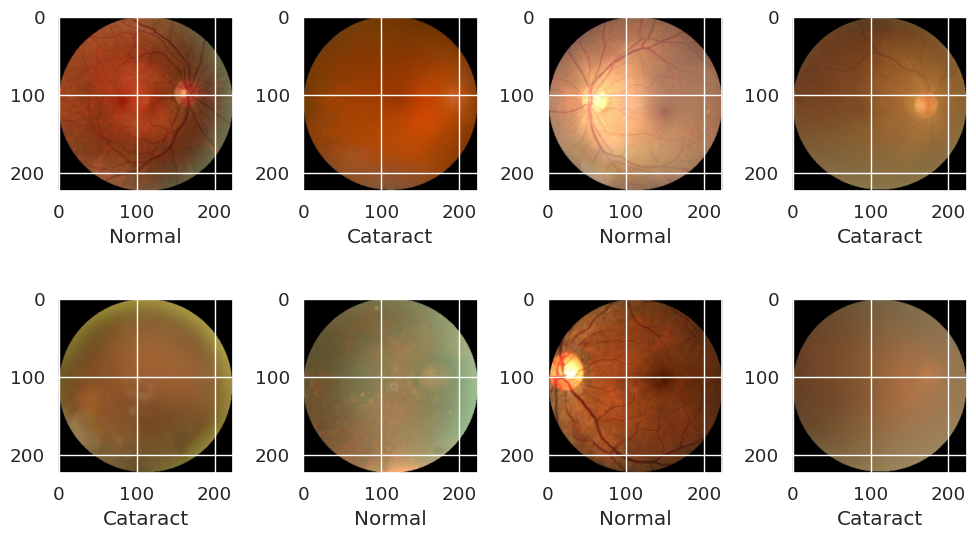

In [ ]:
plot_images(dataset_nc, "Normal", "Cataract")

In [ ]:
x_train, x_validation, x_test, y_train, y_validation, y_test = define_train_test_valid(dataset_nc, image_size)

Epoch 1/15
29/29 [==============================] - ETA: 0s - loss: 0.5914 - accuracy: 0.8922
Epoch 1: val_accuracy improved from 0.80995 to 0.96429, saving model to vgg19.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 13s 301ms/step - loss: 0.5914 - accuracy: 0.8922 - val_loss: 0.1635 - val_accuracy: 0.9643
Epoch 2/15
28/29 [===========================>..] - ETA: 0s - loss: 0.2244 - accuracy: 0.9464
Epoch 2: val_accuracy improved from 0.96429 to 0.98214, saving model to vgg19.h5
29/29 [==============================] - 3s 101ms/step - loss: 0.2234 - accuracy: 0.9467 - val_loss: 0.0944 - val_accuracy: 0.9821
Epoch 3/15
28/29 [===========================>..] - ETA: 0s - loss: 0.0603 - accuracy: 0.9799
Epoch 3: val_accuracy did not improve from 0.98214
29/29 [==============================] - 2s 81ms/step - loss: 0.0601 - accuracy: 0.9800 - val_loss: 0.4265 - val_accuracy: 0.9107
Epoch 4/15
28/29 [===========================>..] - ETA: 0s - loss: 0.0563 - accuracy: 0.9766
Epoch 4: val_accuracy did not improve from 0.98214
29/29 [==============================] - 2s 81ms/step - loss: 0.0560 - accuracy: 0.9767 - val_loss: 0.1585 - val_accuracy: 0.9732
Epoch 5/15
2

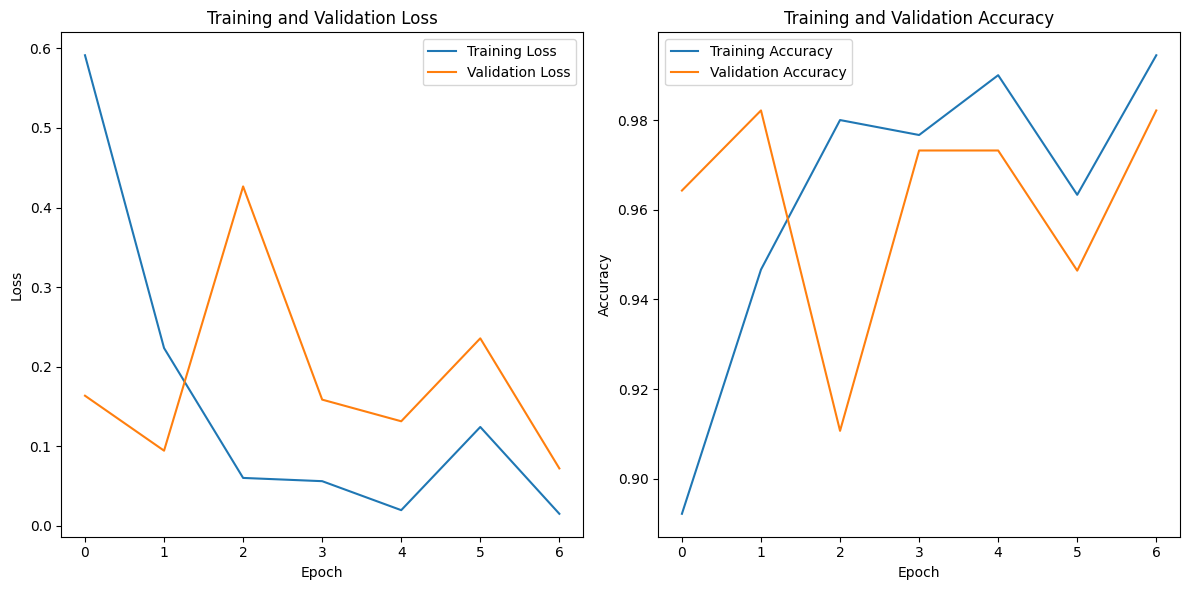

In [ ]:
# model.load_weights(Wsave)
# from keras import backend as K

# curr_session = tf.get_default_session()
# # close current session
# if curr_session is not None:
#     curr_session.close()
# # reset graph
# K.clear_session()
# # create new session
# s = tf.InteractiveSession()
# K.set_session(s)

# history = model.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_test,y_test),
#                     verbose=1,callbacks=[checkpoint,earlystop])
model_cataract = keras.models.load_model('/content/gdrive/MyDrive/DL_files/binary_model.keras')

history = model_cataract.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_validation,y_validation),verbose=1,
                             callbacks=[checkpoint,earlystop])

model_cataract.save('/content/gdrive/MyDrive/DL_files/cataract_model.keras')

plot_train_valid_results(history)

In [ ]:
model_cataract_testing = keras.models.load_model('/content/gdrive/MyDrive/DL_files/cataract_model.keras')


In [ ]:
loss,accuracy = model_cataract_testing.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

4/4 [==============================] - 19s 4s/step - loss: 0.4470 - accuracy: 0.9204
loss: 0.44703903794288635
Accuracy: 0.9203540086746216


In [ ]:
y_pred = model_cataract_testing.predict(x_test)
# print(y_pred)

4/4 [==============================] - 12s 3s/step


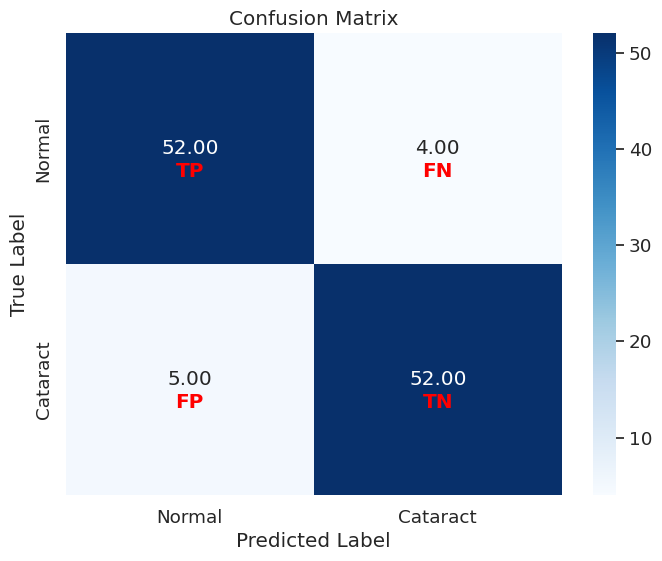

In [ ]:
cm = confusion_matrix(y_test, np.round(y_pred))
plot_cm(cm)

DIABETIC RETINOPATHY

In [ ]:
# LOAD DATASET

# For binary Normal-Diabetes
with open('/content/gdrive/MyDrive/DL_files/my_new_datasets/diabetes_dataset.pkl', 'rb') as file:
    dataset_nd = pickle.load(file)

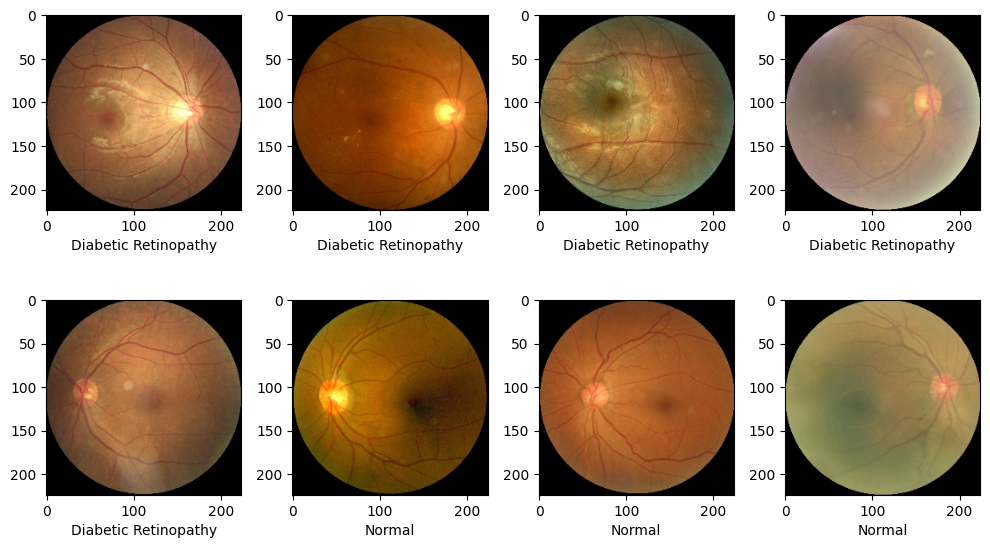

In [ ]:
plot_images(dataset_nd, "Normal", "Diabetic Retinopathy")

In [ ]:
x_train, x_validation, x_test, y_train, y_validation, y_test = define_train_test_valid(dataset_nd, image_size)

Epoch 1/15
156/156 [==============================] - ETA: 0s - loss: 1.1057 - accuracy: 0.6212
Epoch 1: val_accuracy improved from -inf to 0.53698, saving model to vgg19.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


156/156 [==============================] - 32s 116ms/step - loss: 1.1057 - accuracy: 0.6212 - val_loss: 1.1897 - val_accuracy: 0.5370
Epoch 2/15
155/156 [============================>.] - ETA: 0s - loss: 0.5686 - accuracy: 0.7548
Epoch 2: val_accuracy improved from 0.53698 to 0.76206, saving model to vgg19.h5
156/156 [==============================] - 13s 87ms/step - loss: 0.5670 - accuracy: 0.7556 - val_loss: 0.5352 - val_accuracy: 0.7621
Epoch 3/15
155/156 [============================>.] - ETA: 0s - loss: 0.3832 - accuracy: 0.8359
Epoch 3: val_accuracy improved from 0.76206 to 0.78457, saving model to vgg19.h5
156/156 [==============================] - 14s 87ms/step - loss: 0.3826 - accuracy: 0.8360 - val_loss: 0.5147 - val_accuracy: 0.7846
Epoch 4/15
156/156 [==============================] - ETA: 0s - loss: 0.2551 - accuracy: 0.8979
Epoch 4: val_accuracy improved from 0.78457 to 0.84566, saving model to vgg19.h5
156/156 [==============================] - 15s 95ms/step - loss: 0.25

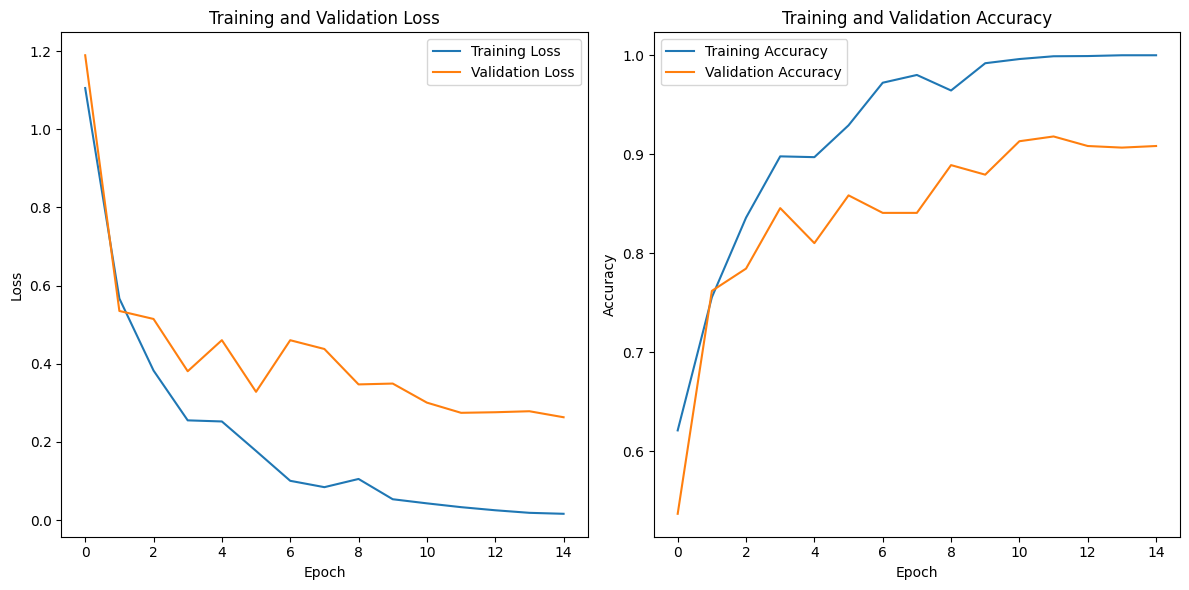

In [ ]:
# Training for Diabetic Retinopathy

# tf.keras.backend.clear_session()
model_diabetes = keras.models.load_model('/content/gdrive/MyDrive/DL_files/binary_model.keras')

history = model_diabetes.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_validation,y_validation),
                    verbose=1,callbacks=[checkpoint,earlystop])

model_diabetes.save('/content/gdrive/MyDrive/DL_files/diabetes_model.keras')

plot_train_valid_results(history)


In [ ]:
model_diabetes_testing = keras.models.load_model('/content/gdrive/MyDrive/DL_files/diabetes_model.keras')

In [ ]:
loss,accuracy = model_diabetes_testing.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

20/20 [==============================] - 4s 78ms/step - loss: 0.3813 - accuracy: 0.8923
loss: 0.38132694363594055
Accuracy: 0.8922829627990723


In [ ]:
y_pred = model_diabetes_testing.predict(x_test)

20/20 [==============================] - 3s 71ms/step


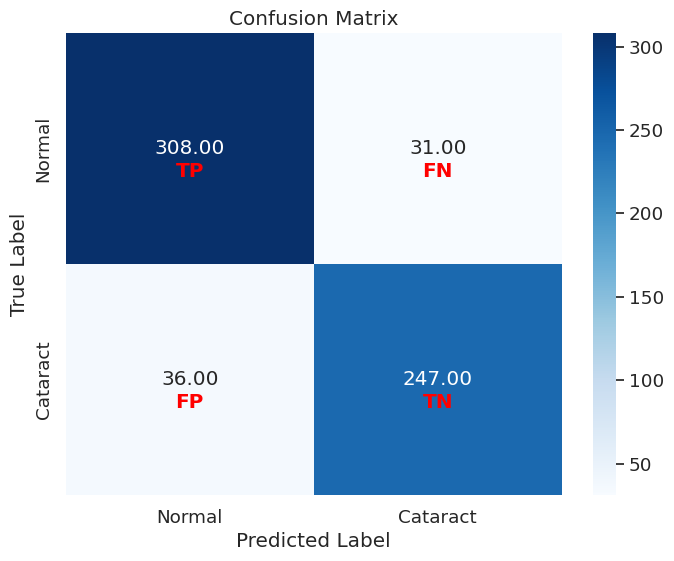

In [ ]:
cm = confusion_matrix(y_test, np.round(y_pred))
plot_cm(cm)

GLAUCOMA

In [ ]:
# LOAD THE DATA

# For binary Normal-Glaucoma
with open('/content/gdrive/MyDrive/DL_files/my_new_datasets/glaucoma_dataset.pkl', 'rb') as file:
    dataset_ng = pickle.load(file)

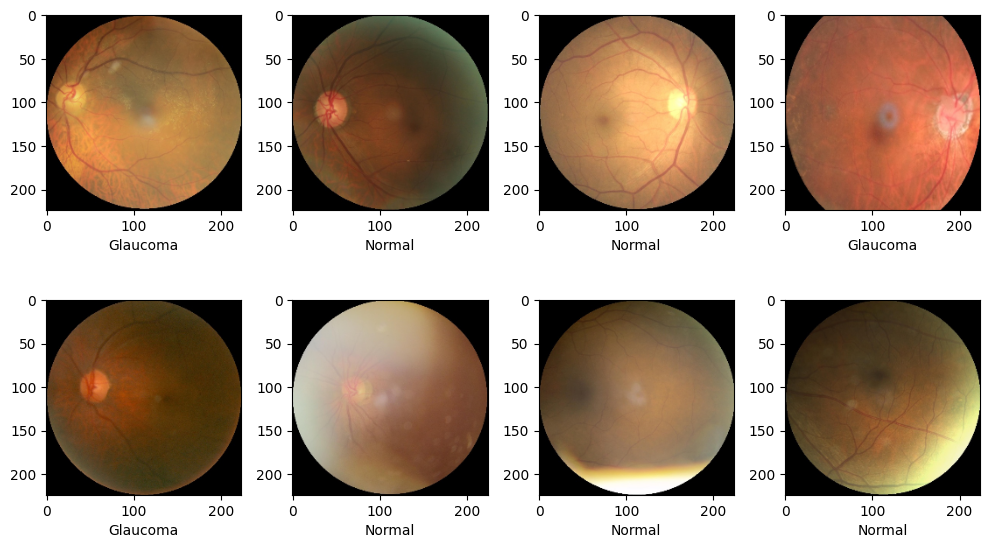

In [ ]:
plot_images(dataset_ng, "Normal", "Glaucoma")


In [ ]:
x_train, x_validation, x_test, y_train, y_validation, y_test = define_train_test_valid(dataset_ng, image_size)

Epoch 1/15
31/31 [==============================] - ETA: 0s - loss: 2.0000 - accuracy: 0.6412
Epoch 1: val_accuracy improved from -inf to 0.74380, saving model to vgg19.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 21s 234ms/step - loss: 2.0000 - accuracy: 0.6412 - val_loss: 1.0953 - val_accuracy: 0.7438
Epoch 2/15
30/31 [============================>.] - ETA: 0s - loss: 0.5140 - accuracy: 0.8313
Epoch 2: val_accuracy did not improve from 0.74380
31/31 [==============================] - 3s 87ms/step - loss: 0.5131 - accuracy: 0.8314 - val_loss: 0.7115 - val_accuracy: 0.7438
Epoch 3/15
30/31 [============================>.] - ETA: 0s - loss: 0.2081 - accuracy: 0.9219
Epoch 3: val_accuracy did not improve from 0.74380
31/31 [==============================] - 3s 90ms/step - loss: 0.2099 - accuracy: 0.9204 - val_loss: 0.6258 - val_accuracy: 0.7190
Epoch 4/15
30/31 [============================>.] - ETA: 0s - loss: 0.2428 - accuracy: 0.8896
Epoch 4: val_accuracy improved from 0.74380 to 0.77686, saving model to vgg19.h5
31/31 [==============================] - 3s 98ms/step - loss: 0.2411 - accuracy: 0.8904 - val_loss: 0.7705 - val_accuracy: 0.7769
Epoch 5/15
30

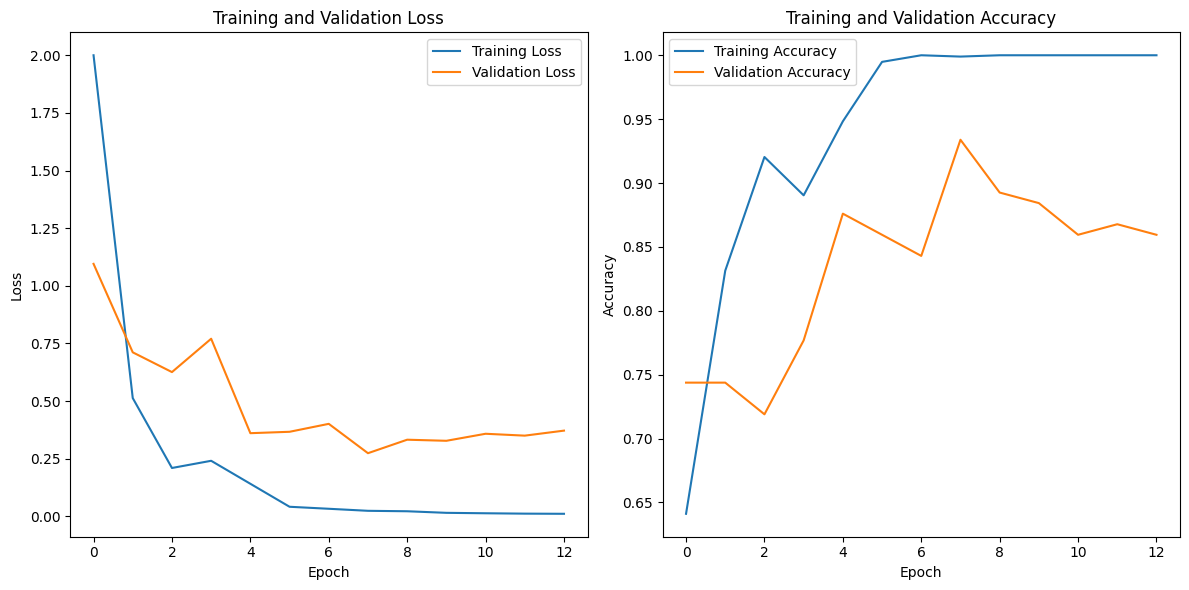

NameError: ignored

In [ ]:
# tf.keras.backend.clear_session()

# model.load_weights(Wsave)

model_glaucoma = keras.models.load_model('/content/gdrive/MyDrive/DL_files/binary_model.keras')

history = model_glaucoma.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_validation,y_validation),verbose=1,
                             callbacks=[checkpoint,earlystop])

model_glaucoma.save('/content/gdrive/MyDrive/DL_files/glaucoma_model.keras')

plot_train_valid_results(history)

In [ ]:
model_glaucoma_testing = keras.models.load_model('/content/gdrive/MyDrive/DL_files/glaucoma_model.keras')

In [ ]:
loss,accuracy = model_glaucoma_testing.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

4/4 [==============================] - 5s 127ms/step - loss: 0.2774 - accuracy: 0.9174
loss: 0.2774253487586975
Accuracy: 0.9173553586006165


In [ ]:
y_pred = model_glaucoma_testing.predict(x_test)

4/4 [==============================] - 4s 94ms/step


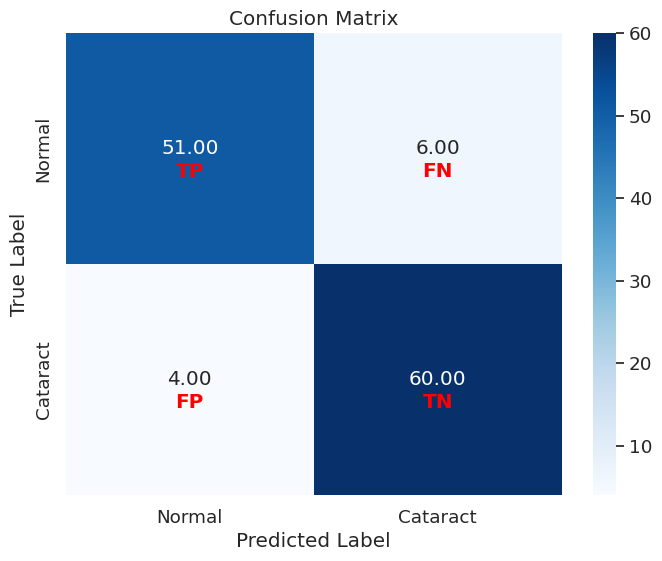

In [ ]:
cm = confusion_matrix(y_test, np.round(y_pred))
plot_cm(cm)

FOR AMD

In [ ]:
# LOAD THE DATASET

# For binary Normal-AMD
with open('/content/gdrive/MyDrive/DL_files/my_new_datasets/AMD_dataset.pkl', 'rb') as file:
    dataset_na = pickle.load(file)

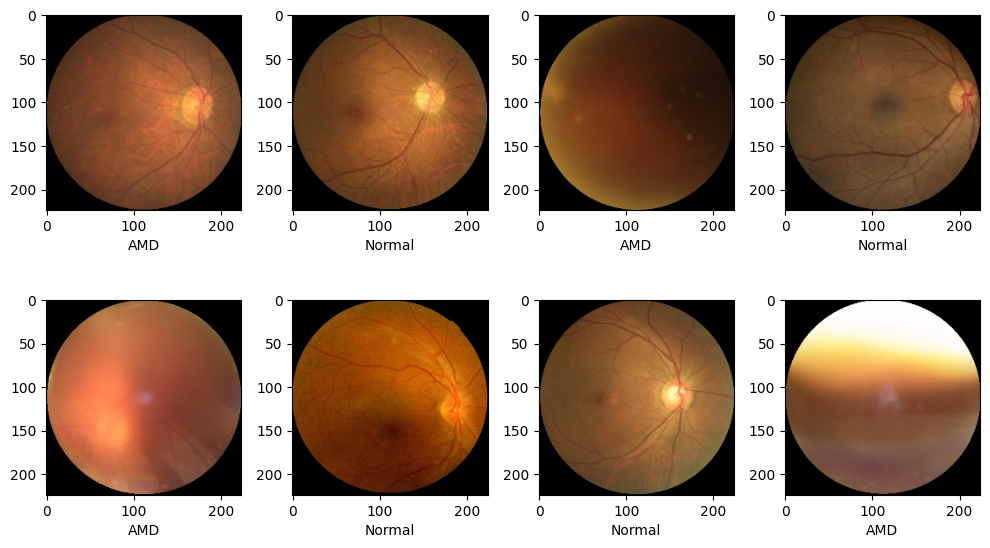

In [ ]:
plot_images(dataset_na, "Normal", "AMD")

In [ ]:
x_train, x_validation, x_test, y_train, y_validation, y_test = define_train_test_valid(dataset_na, image_size)

Epoch 1/15
27/27 [==============================] - ETA: 0s - loss: 1.9013 - accuracy: 0.7124
Epoch 1: val_accuracy improved from -inf to 0.78302, saving model to vgg19.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 20s 226ms/step - loss: 1.9013 - accuracy: 0.7124 - val_loss: 0.7705 - val_accuracy: 0.7830
Epoch 2/15
26/27 [===========================>..] - ETA: 0s - loss: 0.2925 - accuracy: 0.8930
Epoch 2: val_accuracy improved from 0.78302 to 0.91509, saving model to vgg19.h5
27/27 [==============================] - 3s 114ms/step - loss: 0.2938 - accuracy: 0.8935 - val_loss: 0.2362 - val_accuracy: 0.9151
Epoch 3/15
26/27 [===========================>..] - ETA: 0s - loss: 0.0996 - accuracy: 0.9627
Epoch 3: val_accuracy did not improve from 0.91509
27/27 [==============================] - 2s 89ms/step - loss: 0.0990 - accuracy: 0.9633 - val_loss: 0.1987 - val_accuracy: 0.9151
Epoch 4/15
26/27 [===========================>..] - ETA: 0s - loss: 0.0480 - accuracy: 0.9904
Epoch 4: val_accuracy improved from 0.91509 to 0.93396, saving model to vgg19.h5
27/27 [==============================] - 3s 99ms/step - loss: 0.0475 - accuracy: 0.9905 - val_loss: 0.1888 - val

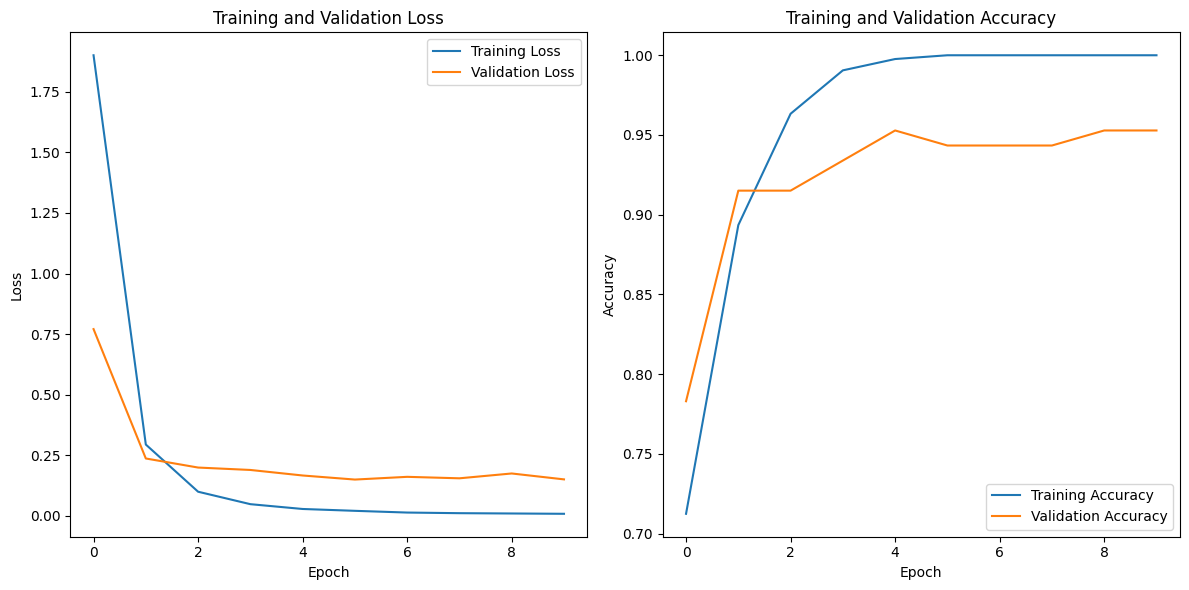

In [ ]:
model_AMD = keras.models.load_model('/content/gdrive/MyDrive/DL_files/binary_model.keras')

history = model_AMD.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_validation,y_validation),verbose=1,
                             callbacks=[checkpoint,earlystop])

model_AMD.save('/content/gdrive/MyDrive/DL_files/AMD_model.keras')

plot_train_valid_results(history)

In [ ]:
model_AMD_testing = keras.models.load_model('/content/gdrive/MyDrive/DL_files/AMD_model.keras')

In [ ]:
loss,accuracy = model_AMD_testing.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

4/4 [==============================] - 2s 71ms/step - loss: 0.1390 - accuracy: 0.9528
loss: 0.13899214565753937
Accuracy: 0.9528301954269409


In [ ]:
y_pred = model_AMD_testing.predict(x_test)

4/4 [==============================] - 2s 86ms/step


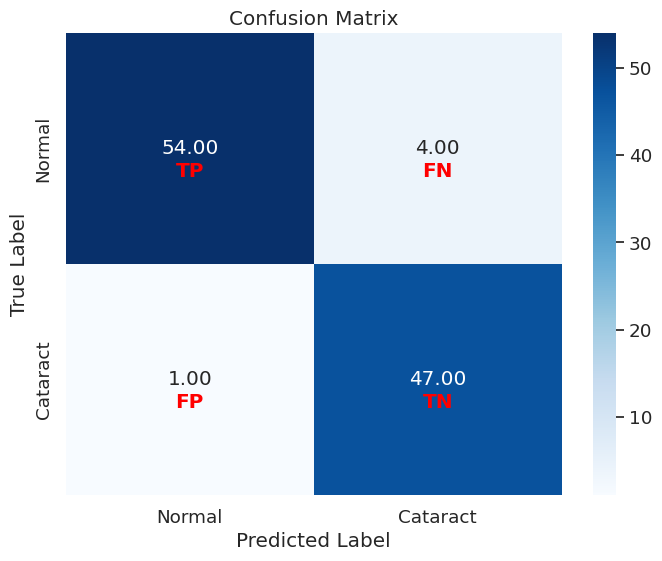

In [ ]:
cm = confusion_matrix(y_test, np.round(y_pred))
plot_cm(cm)

# Multilabel classification

In [ ]:
# For multi-label classification
with open('/content/gdrive/MyDrive/DL_files/my_new_datasets/multi_dataset.pkl', 'rb') as file:
    dataset_multi = pickle.load(file)

print(len(dataset_multi))

2215


In [ ]:
x_train, x_validation, x_test, y_train, y_validation, y_test= define_train_test_valid(dataset_multi, image_size)

#Convert our class vectors (integers) to binary class matrices
y_train_cat = to_categorical(y_train,num_classes=5)
y_validation_cat = to_categorical(y_validation,num_classes = 5)
y_test_cat = to_categorical(y_test,num_classes = 5)

In [ ]:
# Plotting the starting dataset


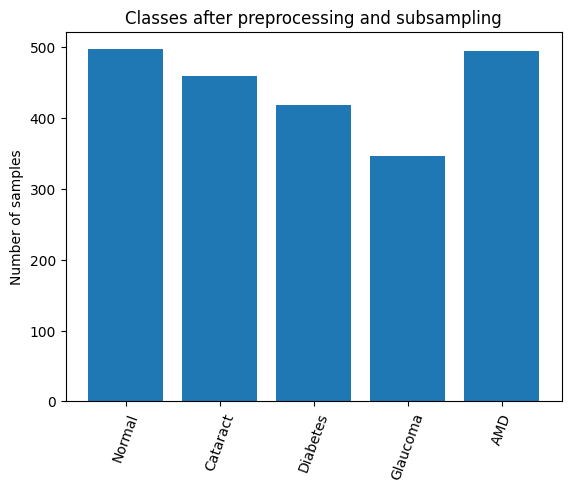

In [ ]:
# Plotting the downsampled data

from collections import Counter

value_counts = Counter((np.array([i[1] for i in dataset_multi])))

plt.bar(np.arange(5), value_counts.values(), width=0.8, bottom=None, align='center', data=None,
        tick_label=("Normal", "Cataract", "Diabetes", "Glaucoma", "AMD"))
plt.xticks(rotation=70)
plt.title("Classes after preprocessing and subsampling")
plt.ylabel("Number of samples")
plt.show()

In [ ]:
InceptionV3_multi = InceptionV3(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3)) #, classifier_activation="sigmoid"?
# InceptionV3 = InceptionV3(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))



In [ ]:
InceptionV3_multi.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
for layer in InceptionV3_multi.layers:
    layer.trainable = False


# Experiment

In [ ]:
x = tf.keras.layers.Flatten()( InceptionV3_multi.output )
x = tf.keras.layers.Dense(1_000, activation='relu')( x )
outputs = tf.keras.layers.Dense(5, activation='softmax')( x )

model_multi_experiment = tf.keras.models.Model( InceptionV3_multi.input , outputs )

In [ ]:
model_multi_experiment.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0]

In [ ]:
model_multi_experiment.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"]) # Categorical crossentropy for multiclass


In [ ]:
model_multi_experiment.save('/content/gdrive/MyDrive/DL_files/multi_model_new.keras')


Epoch 1/15
56/56 [==============================] - ETA: 0s - loss: 14.7810 - accuracy: 0.4780
Epoch 1: val_accuracy improved from -inf to 0.55204, saving model to vgg19.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/56 [==============================] - 29s 280ms/step - loss: 14.7810 - accuracy: 0.4780 - val_loss: 2.1009 - val_accuracy: 0.5520
Epoch 2/15
56/56 [==============================] - ETA: 0s - loss: 1.2840 - accuracy: 0.6879
Epoch 2: val_accuracy improved from 0.55204 to 0.59276, saving model to vgg19.h5
56/56 [==============================] - 16s 284ms/step - loss: 1.2840 - accuracy: 0.6879 - val_loss: 1.2388 - val_accuracy: 0.5928
Epoch 3/15
55/56 [============================>.] - ETA: 0s - loss: 0.4515 - accuracy: 0.8472
Epoch 3: val_accuracy improved from 0.59276 to 0.73756, saving model to vgg19.h5
56/56 [==============================] - 13s 226ms/step - loss: 0.4509 - accuracy: 0.8471 - val_loss: 0.8155 - val_accuracy: 0.7376
Epoch 4/15
56/56 [==============================] - ETA: 0s - loss: 0.2722 - accuracy: 0.9007
Epoch 4: val_accuracy did not improve from 0.73756
56/56 [==============================] - 5s 90ms/step - loss: 0.2722 - accuracy: 0.9007 - val_loss: 1.4176 -

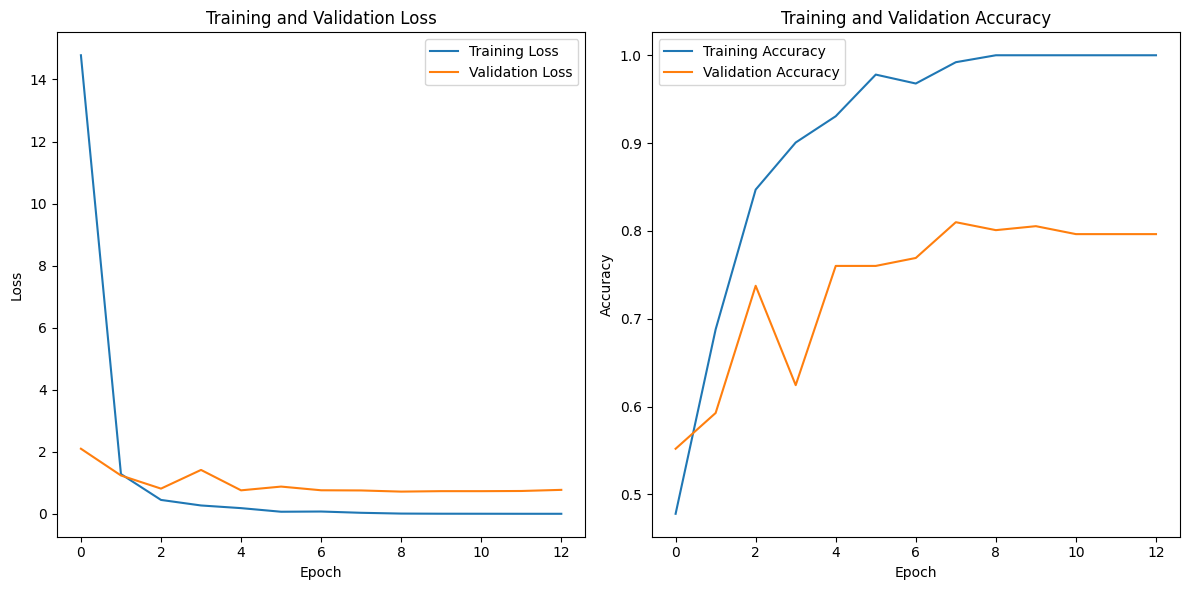

In [ ]:
# Training for Multi-label

# tf.keras.backend.clear_session()
model_multi = keras.models.load_model('/content/gdrive/MyDrive/DL_files/multi_model_new.keras')

history_multi = model_multi.fit(x_train,y_train_cat,batch_size=32,epochs=15,validation_data=(x_validation,y_validation_cat),
                    verbose=1,callbacks=[checkpoint,earlystop])

model_multi.save('/content/gdrive/MyDrive/DL_files/multi_model_testing_new.keras')

plot_train_valid_results(history_multi)

In [ ]:
model_multi_testing = keras.models.load_model('/content/gdrive/MyDrive/DL_files/multi_model_testing_new.keras')

In [ ]:
loss,accuracy = model_multi_testing.evaluate(x_test,y_test_cat)
print("Loss:",loss)
print("Accuracy:",accuracy)

7/7 [==============================] - 27s 4s/step - loss: 0.9209 - accuracy: 0.7613
Loss: 0.9208812117576599
Accuracy: 0.7612612843513489


In [ ]:
# y_pred = np.array((model.predict(x_test) > 0.5).astype("int32"))
y_pred = []
for i in model_multi_testing.predict(x_test):
    y_pred.append(np.argmax(np.array(i)).astype("int32"))

# print(y_pred)
print(classification_report(y_test,y_pred))

7/7 [==============================] - 29s 4s/step
              precision    recall  f1-score   support

           0       0.66      0.45      0.53        56
           1       0.94      1.00      0.97        44
           2       0.50      0.59      0.54        39
           3       0.84      0.92      0.88        51
           4       0.86      0.94      0.90        32

    accuracy                           0.76       222
   macro avg       0.76      0.78      0.76       222
weighted avg       0.76      0.76      0.75       222



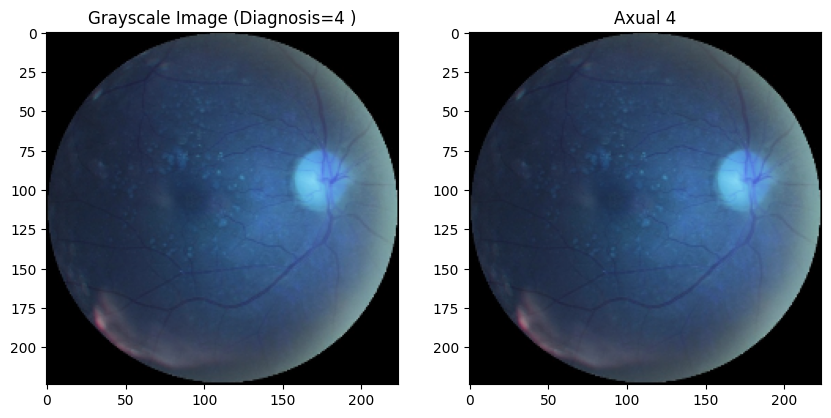

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sample = random.choice(range(150))
img = dataset_multi[sample][0]

axs[0].imshow(img, cmap='gray')
axs[0].set_title(f'Grayscale Image (Diagnosis={y_pred[sample]} )')
axs[0].grid(False)

# print(type(dataset_multi[5][0]))
# print(type(adj_dataset[5][0]))

# Show the second image in the right subplot

axs[1].imshow(img, cmap='gray')
p = dataset_multi[sample][1]
axs[1].set_title(f"Axual {p}")
axs[1].grid(False)


# FOR INCREASED CONTRAST

In [ ]:
def change_contrast(dataset, contrast):
  # Creating a dataset with images with increased contrast

  adj_dataset = [[0] * len(inner_list) for inner_list in dataset]

  # print(len(adj_dataset[0]))

  for i in range(len(dataset)):
    adj_dataset[i][0] = np.asarray(tf.image.adjust_contrast(
        dataset_multi[i][0], contrast
  ))
    adj_dataset[i][1] = dataset[i][1]

  return adj_dataset

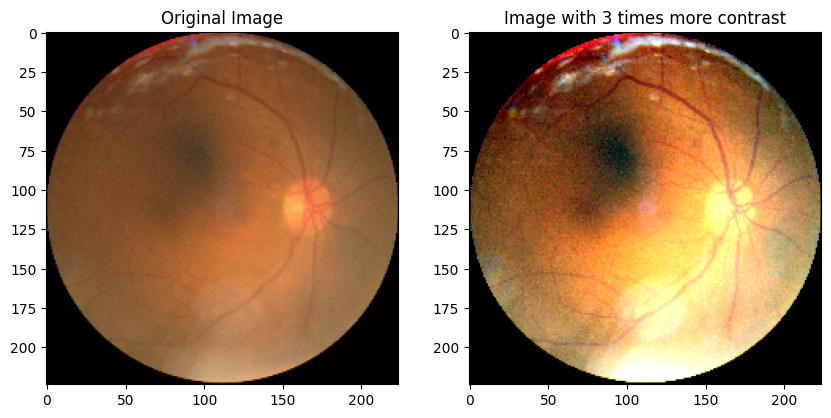

In [ ]:
# Plotting the difference between the two images

adj_dataset = change_contrast(dataset_multi, 3)
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sample = random.choice(range(len(adj_dataset)))

# Show the first image in the left subplot
image_rgb = cv2.cvtColor(dataset_multi[sample][0], cv2.COLOR_BGR2RGB)

axs[0].imshow(image_rgb)
axs[0].set_title('Original Image')
axs[0].grid(False)

# print(type(dataset_multi[5][0]))
# print(type(adj_dataset[5][0]))

# Show the second image in the right subplot
image_rgb2 = cv2.cvtColor(adj_dataset[sample][0], cv2.COLOR_BGR2RGB)

axs[1].imshow(image_rgb2)
axs[1].set_title(f'Image with {3} times more contrast')
axs[1].grid(False)

# Display the images
plt.show()

In [ ]:
# FOR INCREASED CONTRAST

x_train, x_validation, x_test, y_train, y_validation, y_test= define_train_test_valid(adj_dataset, image_size)

#Convert our class vectors (integers) to binary class matrices
y_train_cat = to_categorical(y_train,num_classes=5)
y_validation_cat = to_categorical(y_validation,num_classes = 5)
y_test_cat = to_categorical(y_test,num_classes = 5)

Epoch 1/15
56/56 [==============================] - ETA: 0s - loss: 4.6640 - accuracy: 0.5034
Epoch 1: val_accuracy did not improve from 0.95283
56/56 [==============================] - 14s 173ms/step - loss: 4.6640 - accuracy: 0.5034 - val_loss: 3.4590 - val_accuracy: 0.5249
Epoch 2/15
55/56 [============================>.] - ETA: 0s - loss: 1.3176 - accuracy: 0.7159
Epoch 2: val_accuracy did not improve from 0.95283
56/56 [==============================] - 4s 81ms/step - loss: 1.3155 - accuracy: 0.7156 - val_loss: 1.6317 - val_accuracy: 0.6335
Epoch 3/15
55/56 [============================>.] - ETA: 0s - loss: 0.8174 - accuracy: 0.8011
Epoch 3: val_accuracy did not improve from 0.95283
56/56 [==============================] - 5s 81ms/step - loss: 0.8177 - accuracy: 0.8019 - val_loss: 2.8899 - val_accuracy: 0.5928
Epoch 4/15
55/56 [============================>.] - ETA: 0s - loss: 0.4836 - accuracy: 0.8676
Epoch 4: val_accuracy did not improve from 0.95283
56/56 [=====================

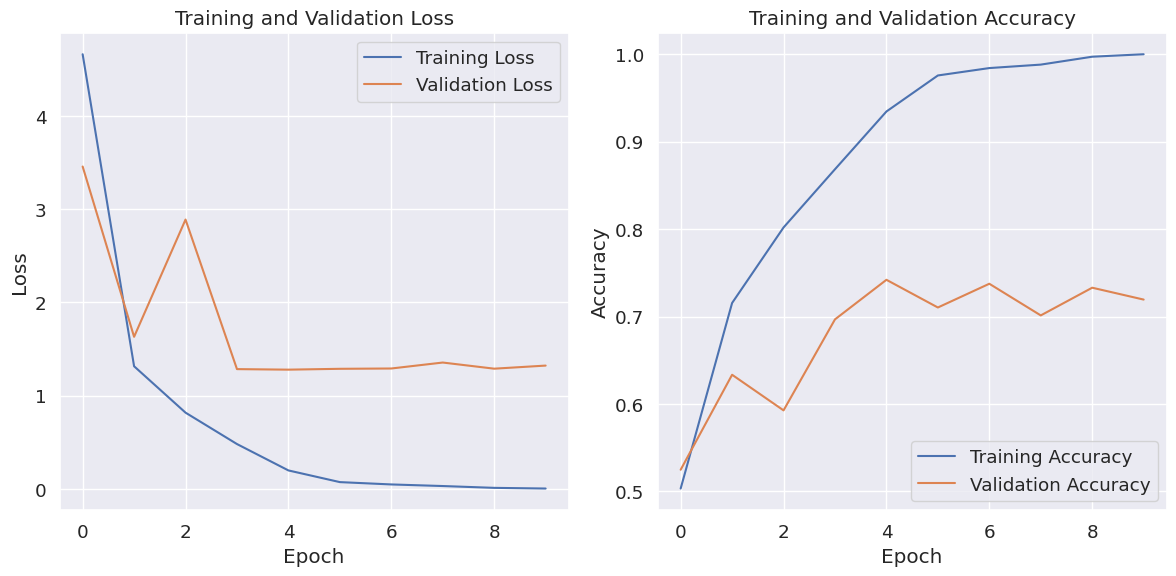

In [ ]:
# Training for Multi-label

# tf.keras.backend.clear_session()
model_multi = keras.models.load_model('/content/gdrive/MyDrive/DL_files/multi_model_new.keras')

history_multi = model_multi.fit(x_train,y_train_cat,batch_size=32,epochs=15,validation_data=(x_validation,y_validation_cat),
                    verbose=1,callbacks=[checkpoint,earlystop])

model_multi.save('/content/gdrive/MyDrive/DL_files/multi_model_adj_testing.keras')

plot_train_valid_results(history_multi)

In [ ]:
model_multi_adj_testing = keras.models.load_model('/content/gdrive/MyDrive/DL_files/multi_model_adj_testing.keras')

In [ ]:
loss,accuracy = model_multi_adj_testing.evaluate(x_test,y_test_cat)
print("Loss:",loss)
print("Accuracy:",accuracy)

7/7 [==============================] - 4s 304ms/step - loss: 1.1501 - accuracy: 0.7928
Loss: 1.1501272916793823
Accuracy: 0.792792797088623


In [ ]:
# y_pred = np.array((model.predict(x_test) > 0.5).astype("int32"))
y_pred = []
for i in model_multi_adj_testing.predict(x_test):
    y_pred.append(np.argmax(np.array(i)).astype("int32"))

# print(y_pred)
print(classification_report(y_test,y_pred))

7/7 [==============================] - 2s 75ms/step
              precision    recall  f1-score   support

           0       0.61      0.52      0.56        42
           1       0.98      1.00      0.99        45
           2       0.63      0.59      0.61        44
           3       0.89      0.93      0.91        59
           4       0.76      0.88      0.81        32

    accuracy                           0.79       222
   macro avg       0.77      0.78      0.78       222
weighted avg       0.78      0.79      0.79       222



In [ ]:
# Accuracy-Contrast

In [ ]:
contrast_list = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
losses = []
accuracies = []
for i in contrast_list:
  contrast_dataset = change_contrast(dataset_multi, i)
  x_train, x_validation, x_test, y_train, y_validation, y_test= define_train_test_valid(contrast_dataset, image_size)

  #Convert our class vectors (integers) to binary class matrices
  y_train_cat = to_categorical(y_train,num_classes=5)
  y_validation_cat = to_categorical(y_validation,num_classes = 5)
  y_test_cat = to_categorical(y_test,num_classes = 5)

  model = keras.models.load_model('/content/gdrive/MyDrive/DL_files/multi_model.keras')

  history = model.fit(x_train,y_train_cat,batch_size=32,epochs=15,validation_data=(x_validation,y_validation_cat),
                    verbose=1,callbacks=[checkpoint,earlystop])

  loss,accuracy = model.evaluate(x_test,y_test_cat)

  losses.append(loss)
  accuracies.append(accuracy)

Epoch 1/15
56/56 [==============================] - ETA: 0s - loss: 5.7382 - accuracy: 0.4802
Epoch 1: val_accuracy improved from -inf to 0.49774, saving model to vgg19.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/56 [==============================] - 22s 174ms/step - loss: 5.7382 - accuracy: 0.4802 - val_loss: 3.2760 - val_accuracy: 0.4977
Epoch 2/15
55/56 [============================>.] - ETA: 0s - loss: 1.2680 - accuracy: 0.7040
Epoch 2: val_accuracy improved from 0.49774 to 0.58824, saving model to vgg19.h5
56/56 [==============================] - 5s 93ms/step - loss: 1.2635 - accuracy: 0.7037 - val_loss: 1.8891 - val_accuracy: 0.5882
Epoch 3/15
55/56 [============================>.] - ETA: 0s - loss: 0.5673 - accuracy: 0.8324
Epoch 3: val_accuracy improved from 0.58824 to 0.64253, saving model to vgg19.h5
56/56 [==============================] - 5s 89ms/step - loss: 0.5643 - accuracy: 0.8335 - val_loss: 1.5074 - val_accuracy: 0.6425
Epoch 4/15
56/56 [==============================] - ETA: 0s - loss: 0.2796 - accuracy: 0.9041
Epoch 4: val_accuracy improved from 0.64253 to 0.75566, saving model to vgg19.h5
56/56 [==============================] - 5s 93ms/step - loss: 0.2796 - accuracy: 0.

Epoch 1/15
55/56 [============================>.] - ETA: 0s - loss: 4.1002 - accuracy: 0.4830
Epoch 1: val_accuracy did not improve from 0.75566
56/56 [==============================] - 11s 120ms/step - loss: 4.1148 - accuracy: 0.4819 - val_loss: 4.0929 - val_accuracy: 0.5656
Epoch 2/15
55/56 [============================>.] - ETA: 0s - loss: 1.4362 - accuracy: 0.7182
Epoch 2: val_accuracy did not improve from 0.75566
56/56 [==============================] - 5s 86ms/step - loss: 1.4310 - accuracy: 0.7190 - val_loss: 1.2696 - val_accuracy: 0.7014
Epoch 3/15
55/56 [============================>.] - ETA: 0s - loss: 0.5238 - accuracy: 0.8415
Epoch 3: val_accuracy did not improve from 0.75566
56/56 [==============================] - 4s 79ms/step - loss: 0.5238 - accuracy: 0.8420 - val_loss: 1.2172 - val_accuracy: 0.7149
Epoch 4/15
56/56 [==============================] - ETA: 0s - loss: 0.2374 - accuracy: 0.9148
Epoch 4: val_accuracy did not improve from 0.75566
56/56 [=====================

Epoch 1/15
55/56 [============================>.] - ETA: 0s - loss: 4.5387 - accuracy: 0.4852
Epoch 1: val_accuracy did not improve from 0.81900
56/56 [==============================] - 12s 117ms/step - loss: 4.5217 - accuracy: 0.4853 - val_loss: 3.3647 - val_accuracy: 0.5928
Epoch 2/15
55/56 [============================>.] - ETA: 0s - loss: 1.1922 - accuracy: 0.7312
Epoch 2: val_accuracy did not improve from 0.81900
56/56 [==============================] - 4s 80ms/step - loss: 1.1959 - accuracy: 0.7308 - val_loss: 1.8678 - val_accuracy: 0.6290
Epoch 3/15
55/56 [============================>.] - ETA: 0s - loss: 0.5217 - accuracy: 0.8318
Epoch 3: val_accuracy did not improve from 0.81900
56/56 [==============================] - 5s 83ms/step - loss: 0.5193 - accuracy: 0.8324 - val_loss: 1.2569 - val_accuracy: 0.6833
Epoch 4/15
55/56 [============================>.] - ETA: 0s - loss: 0.2111 - accuracy: 0.9290
Epoch 4: val_accuracy did not improve from 0.81900
56/56 [=====================

Epoch 1/15
55/56 [============================>.] - ETA: 0s - loss: 3.2190 - accuracy: 0.5159
Epoch 1: val_accuracy did not improve from 0.81900
56/56 [==============================] - 11s 111ms/step - loss: 3.2037 - accuracy: 0.5175 - val_loss: 2.6136 - val_accuracy: 0.5158
Epoch 2/15
55/56 [============================>.] - ETA: 0s - loss: 1.1769 - accuracy: 0.7284
Epoch 2: val_accuracy did not improve from 0.81900
56/56 [==============================] - 5s 86ms/step - loss: 1.1736 - accuracy: 0.7291 - val_loss: 2.0543 - val_accuracy: 0.6425
Epoch 3/15
55/56 [============================>.] - ETA: 0s - loss: 0.5185 - accuracy: 0.8443
Epoch 3: val_accuracy did not improve from 0.81900
56/56 [==============================] - 5s 87ms/step - loss: 0.5153 - accuracy: 0.8454 - val_loss: 1.3455 - val_accuracy: 0.7330
Epoch 4/15
55/56 [============================>.] - ETA: 0s - loss: 0.2044 - accuracy: 0.9284
Epoch 4: val_accuracy did not improve from 0.81900
56/56 [=====================

Epoch 1/15
55/56 [============================>.] - ETA: 0s - loss: 5.0528 - accuracy: 0.4801
Epoch 1: val_accuracy did not improve from 0.81900
56/56 [==============================] - 11s 125ms/step - loss: 5.0302 - accuracy: 0.4825 - val_loss: 1.9794 - val_accuracy: 0.5837
Epoch 2/15
55/56 [============================>.] - ETA: 0s - loss: 0.8638 - accuracy: 0.7477
Epoch 2: val_accuracy did not improve from 0.81900
56/56 [==============================] - 5s 85ms/step - loss: 0.8621 - accuracy: 0.7477 - val_loss: 1.1265 - val_accuracy: 0.7330
Epoch 3/15
55/56 [============================>.] - ETA: 0s - loss: 0.3705 - accuracy: 0.8705
Epoch 3: val_accuracy did not improve from 0.81900
56/56 [==============================] - 5s 84ms/step - loss: 0.3727 - accuracy: 0.8696 - val_loss: 1.0338 - val_accuracy: 0.7421
Epoch 4/15
55/56 [============================>.] - ETA: 0s - loss: 0.2543 - accuracy: 0.9125
Epoch 4: val_accuracy did not improve from 0.81900
56/56 [=====================

Epoch 1/15
55/56 [============================>.] - ETA: 0s - loss: 6.1885 - accuracy: 0.4381
Epoch 1: val_accuracy did not improve from 0.81900
56/56 [==============================] - 11s 120ms/step - loss: 6.1630 - accuracy: 0.4385 - val_loss: 2.3263 - val_accuracy: 0.5837
Epoch 2/15
55/56 [============================>.] - ETA: 0s - loss: 0.9735 - accuracy: 0.7563
Epoch 2: val_accuracy did not improve from 0.81900
56/56 [==============================] - 5s 83ms/step - loss: 0.9742 - accuracy: 0.7562 - val_loss: 1.3270 - val_accuracy: 0.6742
Epoch 3/15
55/56 [============================>.] - ETA: 0s - loss: 0.2700 - accuracy: 0.9045
Epoch 3: val_accuracy did not improve from 0.81900
56/56 [==============================] - 5s 82ms/step - loss: 0.2716 - accuracy: 0.9035 - val_loss: 1.1238 - val_accuracy: 0.7059
Epoch 4/15
55/56 [============================>.] - ETA: 0s - loss: 0.3579 - accuracy: 0.8892
Epoch 4: val_accuracy did not improve from 0.81900
56/56 [=====================

Epoch 1/15
55/56 [============================>.] - ETA: 0s - loss: 4.9285 - accuracy: 0.4784
Epoch 1: val_accuracy did not improve from 0.81900
56/56 [==============================] - 12s 117ms/step - loss: 4.9094 - accuracy: 0.4791 - val_loss: 3.1996 - val_accuracy: 0.5520
Epoch 2/15
55/56 [============================>.] - ETA: 0s - loss: 1.6222 - accuracy: 0.6648
Epoch 2: val_accuracy did not improve from 0.81900
56/56 [==============================] - 5s 87ms/step - loss: 1.6465 - accuracy: 0.6614 - val_loss: 1.7403 - val_accuracy: 0.6290
Epoch 3/15
55/56 [============================>.] - ETA: 0s - loss: 0.9012 - accuracy: 0.8017
Epoch 3: val_accuracy did not improve from 0.81900
56/56 [==============================] - 5s 84ms/step - loss: 0.8957 - accuracy: 0.8030 - val_loss: 1.2154 - val_accuracy: 0.7014
Epoch 4/15
55/56 [============================>.] - ETA: 0s - loss: 0.1932 - accuracy: 0.9347
Epoch 4: val_accuracy did not improve from 0.81900
56/56 [=====================

Epoch 1/15
55/56 [============================>.] - ETA: 0s - loss: 5.4817 - accuracy: 0.4722
Epoch 1: val_accuracy did not improve from 0.81900
56/56 [==============================] - 12s 125ms/step - loss: 5.4554 - accuracy: 0.4729 - val_loss: 2.0988 - val_accuracy: 0.6109
Epoch 2/15
55/56 [============================>.] - ETA: 0s - loss: 1.1751 - accuracy: 0.7188
Epoch 2: val_accuracy did not improve from 0.81900
56/56 [==============================] - 5s 85ms/step - loss: 1.1718 - accuracy: 0.7184 - val_loss: 1.2851 - val_accuracy: 0.6833
Epoch 3/15
55/56 [============================>.] - ETA: 0s - loss: 0.7401 - accuracy: 0.8034
Epoch 3: val_accuracy did not improve from 0.81900
56/56 [==============================] - 5s 86ms/step - loss: 0.7366 - accuracy: 0.8042 - val_loss: 1.6799 - val_accuracy: 0.6968
Epoch 4/15
55/56 [============================>.] - ETA: 0s - loss: 0.5080 - accuracy: 0.8574
Epoch 4: val_accuracy did not improve from 0.81900
56/56 [=====================

In [ ]:
# Plot Contrast-loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(contrast_list, losses)
plt.title('Contrast-Induced Loss Dynamics')
plt.xlabel('Contrast')
plt.ylabel('Loss')
plt.legend()

# Plot Contrast-accuracy
plt.subplot(1, 2)
plt.plot(contrast_list, accuracies)
plt.title('Contrast-Induced Accuracy Dynamics')
plt.xlabel('Contrast')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

NameError: ignored

1
(1, 3, 3, 3, 32)


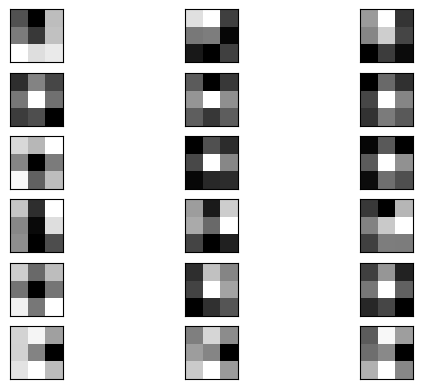

In [ ]:
# Trying to visualize filters

# cannot easily visualize filters lower down


filters = InceptionV3_multi.layers[1].get_weights()
print(len(filters))
filters = np.array(filters)
print(filters.shape)

# plot first few filters
fig = plt.figure(figsize=(4,12))
n_filters, ix = 6, 1
for i in range(n_filters):
 # get the filter
 f = filters[0, :, :, :, i]
 # plot each channel separately
 for j in range(3):
  # specify subplot and turn of axis
  ax = plt.subplot(n_filters, 3, ix)
  ax.set_xticks([])
  ax.set_yticks([])
  # plot filter channel in grayscale
  plt.imshow(f[:, :, j], cmap='gray')
  ix += 1
# show the figure

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 53ms/step


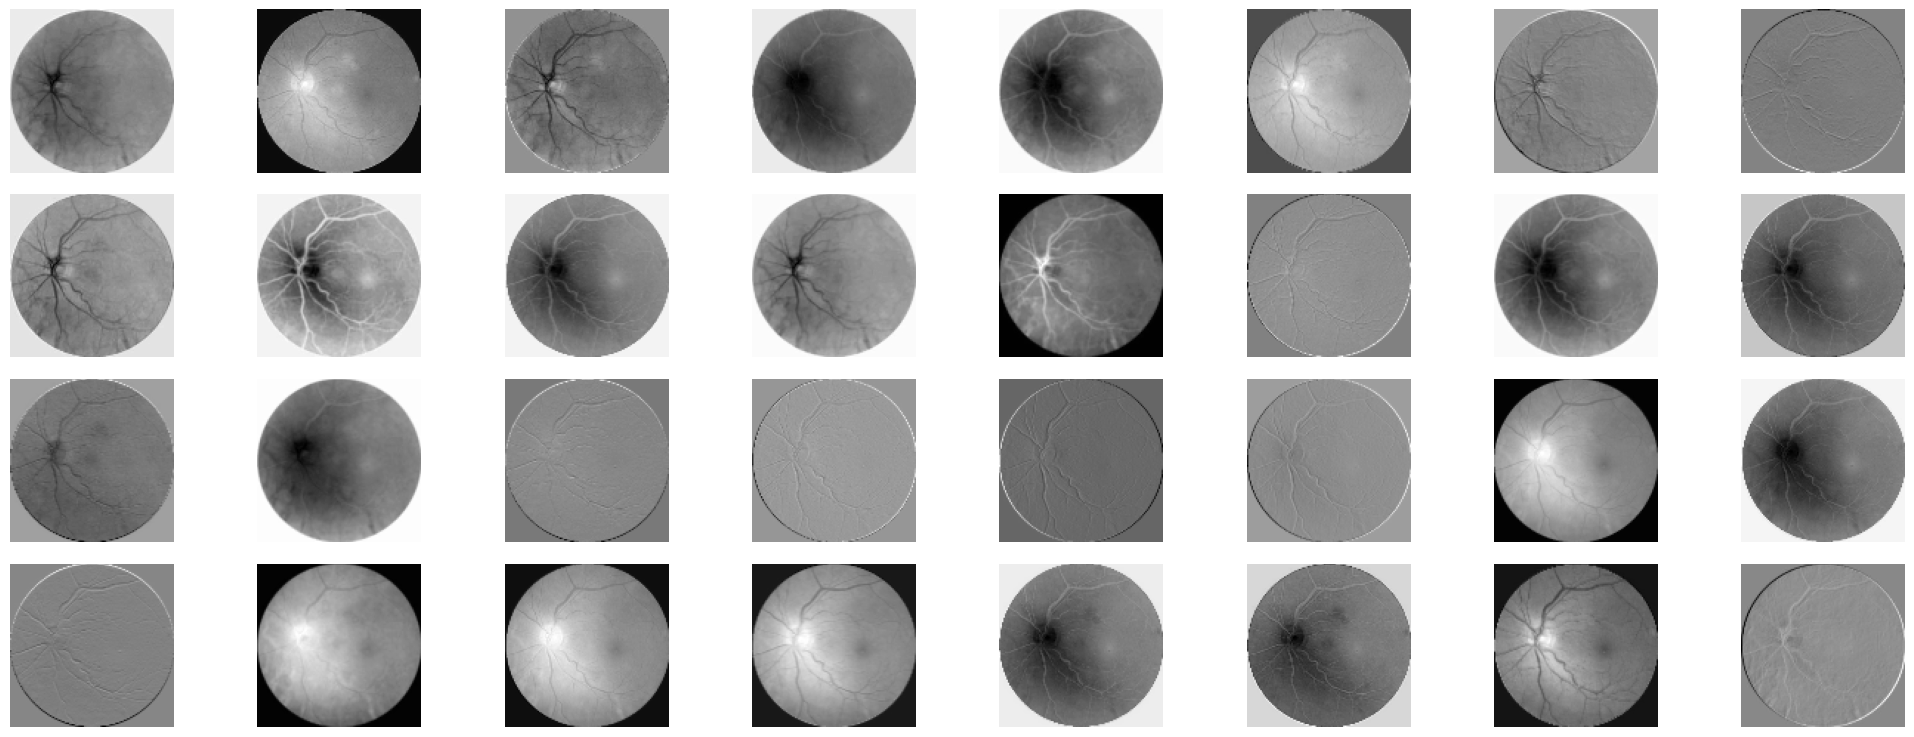

In [ ]:
# Trying to visualize feature maps

model = Model(inputs=InceptionV3_multi.inputs , outputs=InceptionV3_multi.layers[1].output)

sample = random.choice(range(10))
img = x_test[sample]

img = expand_dims(img, axis=0)

img = preprocess_input(img)

features = model.predict(img)

fig = plt.figure(figsize=(20,15))

for i in range(1,features.shape[3]+1):

    plt.subplot(8,8,i)
    plt.imshow(features[0,:,:,i-1] , cmap='gray')
    plt.grid(False)
    plt.axis('off')

plt.tight_layout()

plt.show()

In [ ]:
# GRAD CAM
model = keras.models.load_model('/content/gdrive/MyDrive/DL_files/multi_model_testing_new.keras')

1/1 [==============================] - 0s 153ms/step
Predicted:  Normal
Actual:  AMD
(1, 5, 5)


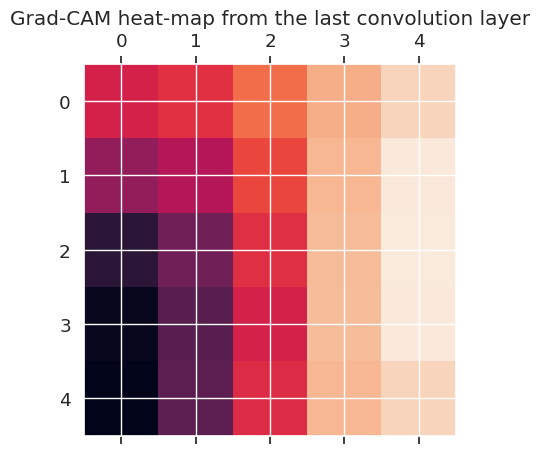

Sample= 40


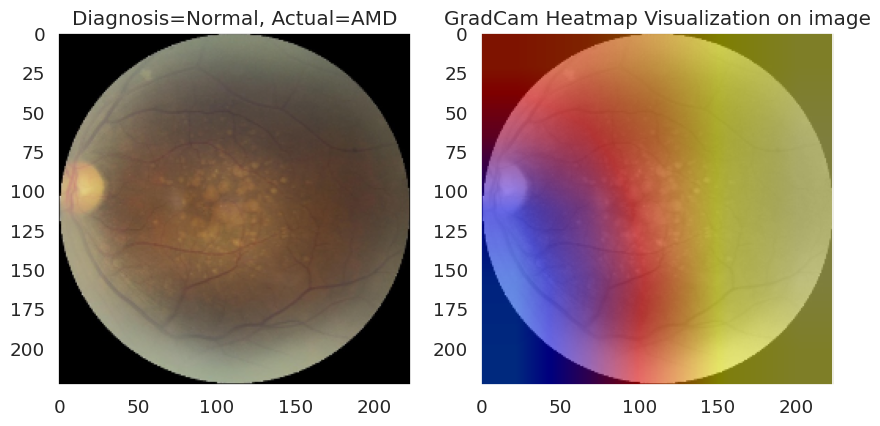

In [ ]:
diagnosis = ['Normal', 'Cataract', 'Diabetes', 'Glaucoma', 'AMD']

sample = random.choice(range(500))
img = dataset_multi[sample][0]
img = expand_dims(img, axis=0)
img = preprocess_input(img)

preds = model.predict(img)
print("Predicted: ",diagnosis[np.argmax(preds).astype("int32")])
print("Actual: ",diagnosis[dataset_multi[sample][1]])


with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer('conv2d_93')
        iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(img)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))

heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = heatmap.reshape((5, 5))
plt.matshow(heatmap)
plt.title('Grad-CAM heat-map from the last convolution layer')
plt.show()

INTENSITY = 0.5

heatmap = cv2.resize(heatmap, (224, 224))
heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
heatmap = 255 - heatmap # Show bright colours as high values

image_rgb = cv2.cvtColor(dataset_multi[sample][0], cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(dataset_multi[sample][0], cv2.COLOR_BGR2GRAY)


print("Sample=",sample)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image_rgb)
axs[0].set_title(f'Diagnosis={diagnosis[np.argmax(preds).astype("int32")]}, Actual={diagnosis[dataset_multi[sample][1]]}')
axs[0].grid(False)

axs[1].imshow(image_gray, cmap='gray')
axs[1].imshow(heatmap, alpha=0.5)
axs[1].set_title('GradCam Heatmap Visualization on image')
axs[1].grid(False)

1/1 [==============================] - 0s 194ms/step
Normal
Predicted:  Normal
Actual:  Normal
conv2d_1
conv2d_2
conv2d_3
conv2d_4
conv2d_8
conv2d_6
conv2d_9
conv2d_5
conv2d_7
conv2d_10
conv2d_11
conv2d_15
conv2d_13
conv2d_16
conv2d_12
conv2d_14
conv2d_17
conv2d_18
conv2d_22
conv2d_20
conv2d_23
conv2d_19
conv2d_21
conv2d_24
conv2d_25
conv2d_27
conv2d_28
conv2d_26
conv2d_29
conv2d_34
conv2d_35
conv2d_31
conv2d_36
conv2d_32
conv2d_37
conv2d_30
conv2d_33
conv2d_38
conv2d_39
conv2d_44
conv2d_45
conv2d_41
conv2d_46
conv2d_42
conv2d_47
conv2d_40


<ipython-input-163-c811d10cadf7>:38: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)


ooops
conv2d_48
conv2d_49
conv2d_54
conv2d_55
conv2d_51
conv2d_56
conv2d_52
conv2d_57
conv2d_50
conv2d_53
conv2d_58
conv2d_59
conv2d_64
conv2d_65
conv2d_61
conv2d_66
conv2d_62
conv2d_67
conv2d_60
conv2d_63
conv2d_68
conv2d_69
conv2d_72
conv2d_73
conv2d_70
conv2d_74
conv2d_71
conv2d_75
conv2d_80
conv2d_77
conv2d_81
conv2d_78
conv2d_79
conv2d_82
conv2d_83
conv2d_76
conv2d_84
conv2d_89
conv2d_86
conv2d_90
conv2d_87
conv2d_88
conv2d_91
conv2d_92
conv2d_85
conv2d_93
[[[ 1.57773948]
  [ 1.57773948]
  [ 1.57773948]
  ...
  [ 0.80992144]
  [ 0.80992144]
  [ 0.80992144]]

 [[ 1.57773948]
  [ 1.57773948]
  [ 1.57773948]
  ...
  [ 0.80992144]
  [ 0.80992144]
  [ 0.80992144]]

 [[ 1.57773948]
  [ 1.57773948]
  [ 1.57773948]
  ...
  [ 0.80992144]
  [ 0.80992144]
  [ 0.80992144]]

 ...

 [[-0.05240256]
  [-0.05240256]
  [-0.05240256]
  ...
  [-0.10227084]
  [-0.10227084]
  [-0.10227084]]

 [[-0.05240256]
  [-0.05240256]
  [-0.05240256]
  ...
  [-0.10227084]
  [-0.10227084]
  [-0.10227084]]

 [[-0.05

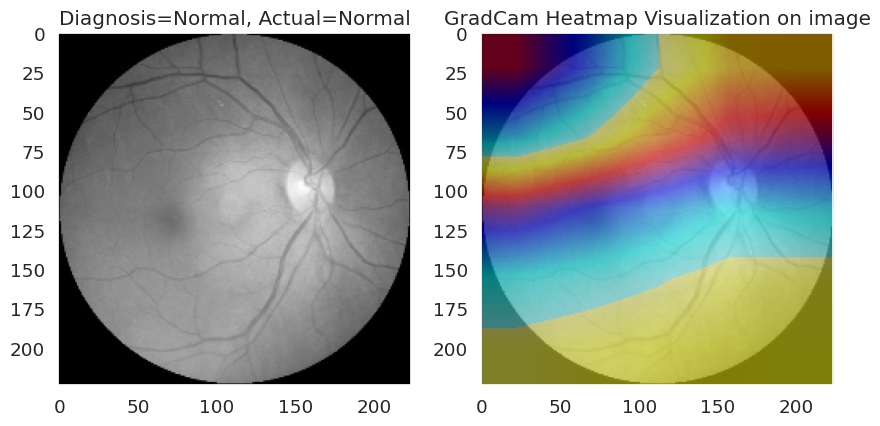

In [ ]:
diagnosis = ['Normal', 'Cataract', 'Diabetes', 'Glaucoma', 'AMD']

sample = random.choice(range(150))

img = dataset_multi[sample][0]
img = expand_dims(img, axis=0)
img = preprocess_input(img)

preds = model.predict(img)
print(diagnosis[np.argmax(preds[0])])
print("Predicted: ",diagnosis[np.argmax(preds).astype("int32")])
print("Actual: ",diagnosis[dataset_multi[sample][1]])


final_heatmap = np.zeros((224,224))
num_layers = 0

for i in range(len(model.layers)):
  layer = model.layers[i]
  if 'conv2d_' not in layer.name:
    continue
  else:
    with tf.GradientTape() as tape:
      last_conv_layer = model.get_layer(layer.name)
      iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
      model_out, last_conv_layer = iterate(img)
      class_out = model_out[:, np.argmax(model_out[0])]
      grads = tape.gradient(class_out, last_conv_layer)
      pooled_grads = K.mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    if np.isnan(heatmap).any():
      print("ooops")
      continue
    else:
      print(layer.name)
      heatmap= heatmap.astype(np.float64)

      heatmap = heatmap.reshape((heatmap.shape[1], heatmap.shape[2]))
      heatmap = cv2.resize(heatmap, (224, 224))
      final_heatmap += heatmap
      num_layers += 1

final_heatmap /= num_layers
final_heatmap  = np.asarray(tf.image.adjust_contrast(expand_dims(heatmap, axis=2), 2))
print(final_heatmap)

INTENSITY = 0.5


final_heatmap = cv2.applyColorMap(np.uint8(255*final_heatmap), cv2.COLORMAP_JET)
final_heatmap = 255 - final_heatmap # Show bright colours as high values

# image_rgb = cv2.cvtColor(dataset_multi[sample][0], cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(dataset_multi[sample][0], cv2.COLOR_BGR2GRAY)

print("Sample=",sample)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image_gray, cmap='gray')
axs[0].set_title(f'Diagnosis={diagnosis[np.argmax(preds).astype("int32")]}, Actual={diagnosis[dataset_multi[sample][1]]}')
axs[0].grid(False)

axs[1].imshow(image_gray, cmap='gray')
axs[1].imshow(final_heatmap, alpha=0.5)
axs[1].set_title('GradCam Heatmap Visualization on image')
axs[1].grid(False)



In [ ]:
model = keras.models.load_model('/content/gdrive/MyDrive/DL_files/binary_model.keras')

In [ ]:
model_cataract_testing = keras.models.load_model('/content/gdrive/MyDrive/DL_files/cataract_model.keras')

1/1 [==============================] - 0s 141ms/step
[[2.5705398e-05]]
Predicted:  Normal
Actual:  Normal
conv2d_1
conv2d_2
conv2d_3
conv2d_4
conv2d_8
conv2d_6
conv2d_9
conv2d_5
conv2d_7
conv2d_10
conv2d_11
conv2d_15
conv2d_13
conv2d_16
conv2d_12
conv2d_14
conv2d_17
conv2d_18
conv2d_22
conv2d_20
conv2d_23
conv2d_19
conv2d_21
conv2d_24
conv2d_25
conv2d_27
conv2d_28
conv2d_26
conv2d_29
conv2d_34
conv2d_35
conv2d_31
conv2d_36
conv2d_32
conv2d_37
conv2d_30
conv2d_33
conv2d_38
conv2d_39
conv2d_44
conv2d_45
conv2d_41
conv2d_46
conv2d_42
conv2d_47
conv2d_40
conv2d_43
conv2d_48
conv2d_49
conv2d_54
conv2d_55
conv2d_51
conv2d_56
conv2d_52
conv2d_57
conv2d_50
conv2d_53
conv2d_58
conv2d_59
conv2d_64
conv2d_65
conv2d_61
conv2d_66
conv2d_62
conv2d_67
conv2d_60
conv2d_63
conv2d_68
conv2d_69
conv2d_72
conv2d_73
conv2d_70
conv2d_74
conv2d_71
conv2d_75
conv2d_80


<ipython-input-164-c3ea75af7765>:39: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)


ooops
conv2d_81
conv2d_78
conv2d_79
conv2d_82
conv2d_83
conv2d_76
conv2d_84
conv2d_89
conv2d_86
conv2d_90
conv2d_87
conv2d_88
conv2d_91
conv2d_92
conv2d_85
conv2d_93
Sample= 23


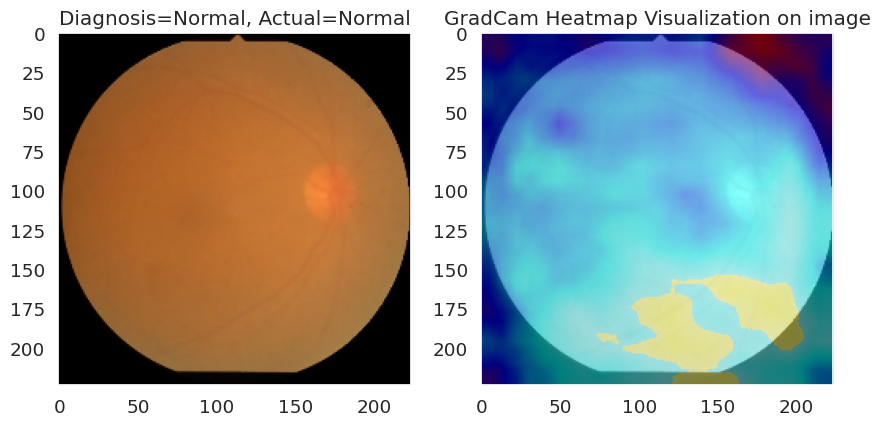

In [ ]:
diagnosis = ['Normal', 'Cataract']

sample = random.choice(range(100))
img = x_test[sample]

img = expand_dims(img, axis=0)

preds = model_cataract_testing.predict(img)
print(preds)
print("Predicted: ",diagnosis[round(preds[0][0])])
print("Actual: ",diagnosis[y_test[sample]])


final_heatmap = np.zeros((224,224))
num_layers = 0

for i in range(len(model_cataract_testing.layers)):
  layer = model_cataract_testing.layers[i]
  if 'conv2d_' not in layer.name:
    continue
  else:
    with tf.GradientTape() as tape:
      last_conv_layer = model_cataract_testing.get_layer(layer.name)
      iterate = tf.keras.models.Model([model_cataract_testing.inputs], [model_cataract_testing.output, last_conv_layer.output])
      model_out, last_conv_layer = iterate(img)
      class_out = model_out[:, np.argmax(model_out[0])]
      grads = tape.gradient(class_out, last_conv_layer)
      pooled_grads = K.mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

    # print(heatmap.shape)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    if np.isnan(heatmap).any():
      print("ooops")
      continue
    else:
      # print(layer.name)
      # print(heatmap)
      heatmap= heatmap.astype(np.float64)

      heatmap = heatmap.reshape((heatmap.shape[1], heatmap.shape[2]))
      heatmap = cv2.resize(heatmap, (224, 224))
      # print(heatmap)
      final_heatmap += heatmap
      num_layers += 1
      # print(final_heatmap)

final_heatmap /= num_layers
final_heatmap  = np.asarray(tf.image.adjust_contrast(expand_dims(final_heatmap, axis=2), 3))


INTENSITY = 0.5


heatmap = cv2.resize(heatmap, (224, 224))
final_heatmap = cv2.applyColorMap(np.uint8(255*final_heatmap), cv2.COLORMAP_JET)
final_heatmap = 255 - final_heatmap # Show bright colours as high values

image_rgb = cv2.cvtColor(dataset_multi[sample][0], cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(dataset_multi[sample][0], cv2.COLOR_BGR2GRAY)

print("Sample=",sample)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image_rgb)
axs[0].set_title(f'Diagnosis={diagnosis[round(preds[0][0])]}, Actual={diagnosis[y_test[sample]]}')
axs[0].grid(False)

axs[1].imshow(image_gray, cmap='gray')
axs[1].imshow(final_heatmap, alpha=0.5)
axs[1].set_title('GradCam Heatmap Visualization on image')
axs[1].grid(False)



# Some plots for the data

In [ ]:
dropped_diseases = ["['H']", "['M']", "['O']"]

dropped_indices = []
for i in range(full_df.shape[0]):
    if full_df['labels'].iloc[i]in dropped_diseases:
        dropped_indices.append(i)

df = full_df[~full_df['labels'].isin(dropped_diseases)]

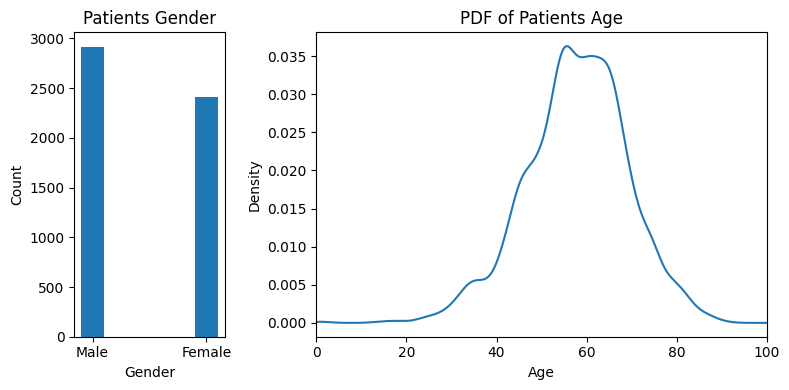

In [ ]:
# Plotting other information about patients

fig, axs = plt.subplots(1, 2, figsize=(8,4),  gridspec_kw={'width_ratios': [1, 3]})
sex = df["Patient Sex"]
sex_count = sex.value_counts()
# sex.value_counts().plot(kind='bar', title='Gender of Patients')
axs[0].bar(np.arange(2), sex_count, width=0.2, bottom=None, align='center', data=None,
        tick_label=('Male', 'Female'))
axs[0].set_ylabel("Count")
axs[0].set_xlabel('Gender')
axs[0].set_title("Patients Gender")

ages = df["Patient Age"]
ages.plot.density(xlim=(0, 100))
plt.title("PDF of Patients Age")
plt.xlabel('Age')
plt.tight_layout()
plt.show()

['N']    2873
['D']     293
['C']    1608
['G']     284
['A']     266
Name: labels, dtype: int64


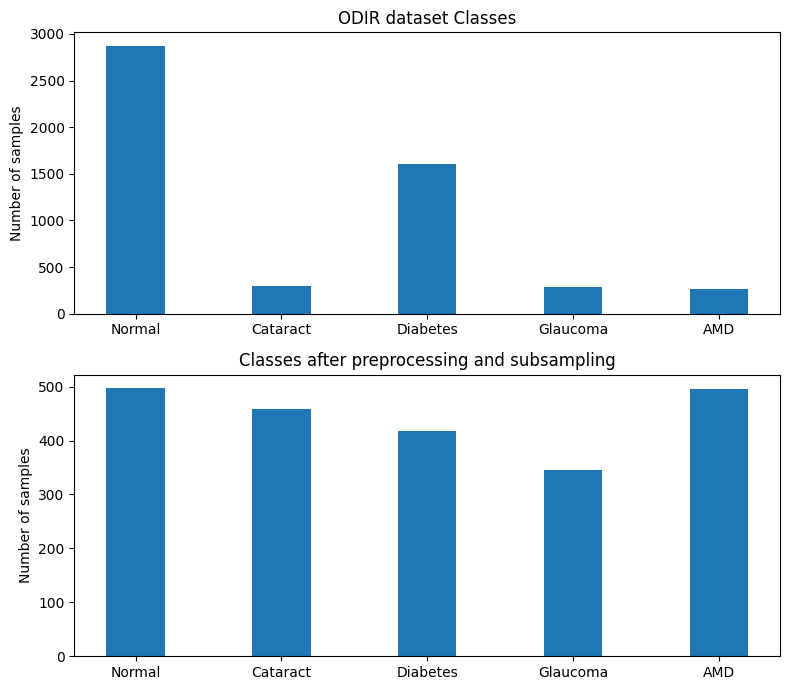

In [ ]:
disease_names = ["Normal",
                "Cataract",
                "Diabetes",
                "Glaucoma",
                "AMD"]

labels = df["labels"]
values = labels.value_counts()
values[1], values[2] = values[2], values[1]
print(values)

fig, axs = plt.subplots(2, figsize=(8,7))
# fig.suptitle('Vertically stacked subplots')

axs[0].bar(np.arange(5), values, width=0.4, bottom=None, align='center', data=None,
        tick_label=disease_names)
axs[0].set_title('ODIR dataset Classes')
axs[0].set_ylabel('Number of samples')


value_count = Counter((np.array([i[1] for i in dataset_multi])))
axs[1].bar(np.arange(5), value_count.values(), width=0.4, bottom=None, align='center', data=None,
        tick_label=disease_names)
axs[1].set_title("Classes after preprocessing and subsampling")
axs[1].set_ylabel('Number of samples')


plt.tight_layout()
plt.show()